In [ ]:
import sys
print(sys.path)

In [ ]:
import os

print (os.environ)

In [ ]:
import pyspark
import random

sc = pyspark.SparkContext(appName="Pi")

num_samples = 100000000

def inside(p):     
  x, y = random.random(), random.random()
  return x*x + y*y < 1

count = sc.parallelize(range(0, num_samples)).filter(inside).count()

pi = 4 * count / num_samples
print(pi)

sc.stop()

In [ ]:
sc.stop()

In [ ]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext
sc= SparkContext()
sqlContext = SQLContext(sc)
house_df = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load('boston.csv')
house_df.take(1)

In [ ]:
import six
for i in house_df.columns:
    if not( isinstance(house_df.select(i).take(1)[0][0], six.string_types)):
        print( "Correlation to MV for ", i, house_df.stat.corr('MV',i))

In [ ]:
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PT', 'B', 'LSTAT'], outputCol = 'features')
vhouse_df = vectorAssembler.transform(house_df)
vhouse_df = vhouse_df.select(['features', 'MV'])
vhouse_df.show(3)

In [ ]:
splits = vhouse_df.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]

In [ ]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol='MV', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_df)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

## Cox model

In [1]:
import s3fs
import pandas as pd
import numpy as np
pd.options.display.max_columns = None
# csv file
df_all = pd.read_csv("s3://eqrs-ngmc-datascience/Datascience/x.csv")
df = df_all#[:50000]

# as.Date(data$strr_pyf_start, format="%m/%d/%Y")
df['strr_pyf_start'] = pd.to_datetime(df['strr_pyf_start']).dt.strftime('%m/%d/%Y')
# df['provfs'] = df['provfs'].astype(str)
df['provfs'] = pd.to_numeric(df['provfs'], downcast='integer', errors='coerce').fillna(0)
df['provfs'] = df['provfs'].astype(int)
col_names = df.columns

# sorting with three columns
z_pd = df.to_records()
z_pd.sort(order=["provfs", "ptnt_id", "year"])
d2 = pd.DataFrame(z_pd)

classnames = (
"pdiab", "pdismiss", "pnhprev", "bmi_msg", "ashd1", "othcardiac1",
"carfail", "noambul", "pulmon", "notrans", "cancer", "diabetes",
"pvasc", "cva", "smoke", "alcoh", "drug", "inci_one", "inci_miss"
)

#R     z <- match(classnames, names(data2))
z = [ list(d2.columns).index(x) if x in d2.columns else None for x in  classnames]

for i in range(0, len(z)):
    col_mean = float(d2.iloc[:, [z[i]]].mean())
    if(col_mean<0.001 or col_mean>0.999):
        print("WARNING: Covariate", classnames[i],"has less than 0.1% variation.  The distribution of this covariate is", col_mean)
    else:
        print("WARNING: Covariate", classnames[i], "has missing values.")



cols = ["ptnt_id", "provfs", "t_trans", "strr_pyf_start", "wt_trans", "ot_trans","pdiab", 
        "pdismiss", "pnhprev",  "logbmi", "bmi_msg", "agecat6", "year", "pyf_period_esrd",  
        "t_start", "t_stop", "ashd1", "othcardiac1", "carfail", "noambul",  "pulmon", 
        "notrans", "cancer", "diabetes", "pvasc", "cva",  "smoke", "alcoh", "drug", "inci_one", "inci_miss"]
z2 = d2[cols]

missing_z2 = z2.isna()

if sum(missing_z2.sum(axis=0))>0:
  print("Warning: There are", sum(missing_z2.sum(axis=0)), "rows with missing data")
  print("Any rows with missing data will be deleted")

allnames= ["ptnt_id","provfs","t_trans", "strr_pyf_start","wt_trans","ot_trans","pdiab","pdismiss",
    "pnhprev","logbmi","bmi_msg","agecat6","year","pyf_period_esrd","t_start","t_stop","ashd1", 
    "othcardiac1", "carfail","noambul", "pulmon", "notrans", "cancer", "diabetes",
    "pvasc", "cva", "smoke","alcoh", "drug","inci_one","inci_miss",
    "strr_period", "pstrr", "trans_yar", "trans_dar"]


data_sub = d2[allnames]
data_sub_complete=data_sub

########################################################################################
#  SECTION 7 (ISSUE #3): CREATE TRANSFUSION EVENT FLAG                                 #
#    -CHECK FOR SMALL NUMBER OF EVENTS                                                 #                                           
########################################################################################
data_sub_complete['t_trans0'] = np.where(data_sub_complete['t_trans']>0, 1, 0)
data_sub_complete['t_trans']=data_sub_complete['t_trans'].apply(lambda x: 1 if x > 0 else 0).copy()
# data_sub_complete.loc[data_sub_complete.t_trans > 1, 't_trans'] = 1
# data_sub_complete.loc[data_sub_complete.t_trans <= 0, 't_trans'] = 0

########################################################################################
#   SECTION 8: SUBSET DATA TO THOSE WITH AT LEAST 1 DAY AT RISK                        #
#     -ALSO SUBSET TO THOSE WITH APPROPRIATE AGE AND ESRD CATEGORIES                   #
#   NOTE: THIS IS MOSTLY DONE JUST TO BE PRECAUTIOUS FOR TEST DATA                     #
########################################################################################
data_sub_complete2 = data_sub_complete[(data_sub_complete['pyf_period_esrd']>0) & (data_sub_complete['agecat6']!=1) & (data_sub_complete['trans_dar']>0)]

########################################################################################
#   SECTION 9 (ISSUE #5): CHECK FOR LINEARLY DEPENDENT COVARIATES                      #
#      NOTE: THIS WON'T PREVENT MODEL FROM RUNNING                                     #
########################################################################################

z_pd = data_sub_complete2.to_records()
z_pd.sort(order=["provfs", "ptnt_id", "year", "strr_pyf_start"])
data_sub_sort = pd.DataFrame(z_pd)
data_chk_rank = data_sub_sort.drop(["strr_pyf_start","provfs","ptnt_id"], axis = 1) 

########################################################################################
#   SECTION 10: RUN DATA THROUGH TWO COX PROPORTIONAL HAZARDS MODELS                   #
########################################################################################
data_sub_sort['year'] = pd.Categorical(data_sub_sort['year'], ordered=False)
data_sub_sort['pdismiss'] = pd.Categorical(data_sub_sort['pdismiss'], categories=[0, 1], ordered=False)
data_sub_sort['pnhprev'] = pd.Categorical(data_sub_sort['pnhprev'], categories=[0, 1], ordered=False)
data_sub_sort['bmi_msg'] = pd.Categorical(data_sub_sort['bmi_msg'], categories=[0, 1], ordered=False)
data_sub_sort['ashd1'] = pd.Categorical(data_sub_sort['ashd1'], categories=[0, 1], ordered=False)
data_sub_sort['othcardiac1'] = pd.Categorical(data_sub_sort['othcardiac1'], categories=[0, 1], ordered=False)
data_sub_sort['carfail'] = pd.Categorical(data_sub_sort['carfail'], categories=[0, 1], ordered=False)
data_sub_sort['noambul'] = pd.Categorical(data_sub_sort['noambul'], categories=[0, 1], ordered=False)
data_sub_sort['pulmon'] = pd.Categorical(data_sub_sort['pulmon'], categories=[0, 1], ordered=False)
data_sub_sort['notrans'] = pd.Categorical(data_sub_sort['notrans'], categories=[0, 1], ordered=False)
data_sub_sort['cancer'] = pd.Categorical(data_sub_sort['cancer'], categories=[0, 1], ordered=False)
data_sub_sort['diabetes'] = pd.Categorical(data_sub_sort['diabetes'], categories=[0, 1], ordered=False)
data_sub_sort['pvasc'] = pd.Categorical(data_sub_sort['pvasc'], categories=[0, 1], ordered=False)
data_sub_sort['cva'] = pd.Categorical(data_sub_sort['cva'], categories=[0, 1], ordered=False)
data_sub_sort['smoke'] = pd.Categorical(data_sub_sort['smoke'], categories=[0, 1], ordered=False)
data_sub_sort['alcoh'] = pd.Categorical(data_sub_sort['alcoh'], categories=[0, 1], ordered=False)
data_sub_sort['drug'] = pd.Categorical(data_sub_sort['drug'], categories=[0, 1], ordered=False)
data_sub_sort['inci_one'] = pd.Categorical(data_sub_sort['inci_one'], categories=[0, 1], ordered=False)
data_sub_sort['inci_miss'] = pd.Categorical(data_sub_sort['inci_miss'], categories=[0, 1], ordered=False)
data_sub_sort['smoke'] = pd.Categorical(data_sub_sort['smoke'], categories=[0, 1], ordered=False)

data_sub_sort['provfs'] = pd.Categorical(data_sub_sort['provfs'], ordered=False)

# coxph_control <- coxph.control(eps = 1e-8)
# data_sub_sort.transform(lambda x: x + 1)

data_model = data_sub_sort

#######################################################################################################################################################
# Run Stage-1 Cox Model
######################################################################################################################################################
import h2o
from h2o.estimators.coxph import H2OCoxProportionalHazardsEstimator
h2o.init()

data_modelt_Full_Sample=data_model
data_modelt_Full_Sample.reset_index(drop=True, inplace=True)

data_modelt_Full_Sample_hex = h2o.H2OFrame(data_modelt_Full_Sample)
data_modelt_Full_Sample_hex[data_modelt_Full_Sample_hex["provfs"].isna(), "provfs"] = 0
# data_modelt_Full_Sample_hex["provfs"] = data_modelt_Full_Sample_hex["provfs"].ascharacter()
# data_modelt_Full_Sample_hex["provfs"] = data_modelt_Full_Sample_hex["provfs"].asfactor()
predictorsSt = list(["agecat6", "pdiab", "pdismiss","notrans","cancer",
                "diabetes","pvasc","year", "pnhprev", "logbmi", 
                "bmi_msg","cva","smoke","alcoh","drug",
                "inci_one", "ashd1", "pulmon","inci_miss","year",
                "othcardiac1", "carfail", "noambul", "pulmon"])

interaction_pairs = [   ("agecat6","pdiab"), 
                        ("pdiab", "pyf_period_esrd")]

strr_h2o_moodel = H2OCoxProportionalHazardsEstimator(
    start_column="t_start",
    stop_column="t_stop",
    offset_column="ot_trans",
    ties="breslow",
#     stratify_by=["provfs"],
#     interaction_pairs=interaction_pairs,
    )

strr_h2o_moodel.train(x=predictorsSt,
                y="t_trans0",
                training_frame=data_modelt_Full_Sample_hex)



###########################
# writing to csv
# pd.DataFrame(data_modelt_Full_Sample_hex["provfs"]).to_csv('provfs.csv')

data_modelt_Full_Sample_hex['provfs'].types

strr_h2o_moodel.coefficients_table
data_modelt_Full_Sample_hex['t_trans0'].types
data_modelt_Full_Sample_hex["t_trans0"]
len(data_modelt_Full_Sample_hex.col_names)
data_modelt_Full_Sample_hex.types

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,2 hours 23 mins
H2O_cluster_timezone:,UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.3
H2O_cluster_version_age:,2 months and 4 days
H2O_cluster_name:,H2O_from_python_root_z8cwc4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,25.25 Gb
H2O_cluster_total_cores:,32
H2O_cluster_allowed_cores:,32
H2O_cluster_status:,"locked, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
coxph Model Build progress: |█████████████████████████████████████████████| 100%


{'index': 'int',
 'ptnt_id': 'int',
 'provfs': 'int',
 't_trans': 'int',
 'strr_pyf_start': 'time',
 'wt_trans': 'int',
 'ot_trans': 'real',
 'pdiab': 'int',
 'pdismiss': 'int',
 'pnhprev': 'int',
 'logbmi': 'real',
 'bmi_msg': 'int',
 'agecat6': 'int',
 'year': 'int',
 'pyf_period_esrd': 'int',
 't_start': 'real',
 't_stop': 'real',
 'ashd1': 'int',
 'othcardiac1': 'int',
 'carfail': 'int',
 'noambul': 'int',
 'pulmon': 'int',
 'notrans': 'int',
 'cancer': 'int',
 'diabetes': 'int',
 'pvasc': 'int',
 'cva': 'int',
 'smoke': 'int',
 'alcoh': 'int',
 'drug': 'int',
 'inci_one': 'int',
 'inci_miss': 'int',
 'strr_period': 'int',
 'pstrr': 'int',
 'trans_yar': 'real',
 'trans_dar': 'int',
 't_trans0': 'int'}

### S3 CSV file read

In [1]:
# import s3fs
import pandas as pd
import numpy as np
pd.options.display.max_columns = None
# csv file
# df_all = pd.read_csv("s3://eqrs-ngmc-datascience/Datascience/x.csv")
df_all = pd.read_csv("c:/project_data/x_strr.csv")

# parquet file
# df = pd.read_parquet('s3://{bucket_name}/{path_to_file}')

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = df_all[:50000]
df.head()

,Unnamed: 0,X,PTNT_MSR_RISK_CHRCTRSTC_ID,ptnt_id,provfs,t_trans,trans_dar,pstrr,wt_trans,ot_trans,pdiab,pdismiss,pnhprev,logbmi,bmi_msg,agecat6,year,pyf_period_esrd,t_start,t_stop,ashd1,othcardiac1,carfail,noambul,pulmon,notrans,cancer,diabetes,pvasc,cva,smoke,alcoh,drug,inci_one,inci_miss,strr_pyf_start,END_DT,PRVDR_ID,DAY_AT_HOSP_CNT,MISG_FRQNT_CMRBDTY_IND,FRQNT_CMRBDTY_TXT,MSR_TYPE_ID,FEML_IND,trans_yar,strr_period
0,1,1,16877082,6216849,262506,0,70,1,1,4.248495,1,0,0,3.133060,0,0,2018,1,0.25,0.5,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,23-OCT-18,31-DEC-18,2848.0,NaN,NaN,NaN,15,NaN,0.191781,1
1,2,2,16877086,6216881,342562,0,51,1,1,3.931826,0,0,0,2.555747,0,6,2018,1,0.25,0.5,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,11-NOV-18,31-DEC-18,6375.0,NaN,NaN,NaN,15,NaN,0.139726,1
2,3,3,16877134,1963204,552733,1,110,1,1,4.700480,1,0,0,3.251380,0,6,2017,6,5.00,6.0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,13-SEP-17,31-DEC-17,4461.0,NaN,NaN,NaN,15,NaN,0.301370,1
3,4,4,16877135,1963204,552733,0,59,1,1,4.077537,1,0,0,3.251380,0,6,2018,6,5.00,6.0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,01-JAN-18,28-FEB-18,4461.0,NaN,NaN,NaN,15,NaN,0.161644,1
4,5,5,16877136,1963204,552733,0,91,0,1,4.510860,1,0,0,3.251380,0,6,2018,6,5.00,6.0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,01-APR-18,30-JUN-18,4461.0,NaN,NaN,NaN,15,NaN,0.249315,1


In [3]:
# as.Date(data$strr_pyf_start, format="%m/%d/%Y")
df['strr_pyf_start'] = pd.to_datetime(df['strr_pyf_start']).dt.strftime('%m/%d/%Y')
# df['provfs'] = df['provfs'].astype(str)
df['provfs'] = pd.to_numeric(df['provfs'], downcast='integer', errors='coerce').fillna(0)
df['provfs'] = df['provfs'].astype(int)

In [4]:
col_names = df.columns
df["provfs"].loc[0]

262506

In [5]:
# sorting with three columns
z_pd = df.to_records()
z_pd.sort(order=["provfs", "ptnt_id", "year"])
d2 = pd.DataFrame(z_pd)
d2

,index,Unnamed: 0,X,PTNT_MSR_RISK_CHRCTRSTC_ID,ptnt_id,provfs,t_trans,trans_dar,pstrr,wt_trans,ot_trans,pdiab,pdismiss,pnhprev,logbmi,bmi_msg,agecat6,year,pyf_period_esrd,t_start,t_stop,ashd1,othcardiac1,carfail,noambul,pulmon,notrans,cancer,diabetes,pvasc,cva,smoke,alcoh,drug,inci_one,inci_miss,strr_pyf_start,END_DT,PRVDR_ID,DAY_AT_HOSP_CNT,MISG_FRQNT_CMRBDTY_IND,FRQNT_CMRBDTY_TXT,MSR_TYPE_ID,FEML_IND,trans_yar,strr_period
0,7540,7541,7541,16893349,915,0,1,92,0,1,4.521789,1,0,1,3.100047,0,6,2016,6,5.0,6.0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,10/01/2016,31-DEC-16,14033.0,NaN,NaN,NaN,15,NaN,0.252055,1
1,7541,7542,7542,16893350,915,0,0,59,1,1,4.077537,1,0,1,3.100047,0,6,2017,6,5.0,6.0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,01/01/2017,28-FEB-17,14033.0,NaN,NaN,NaN,15,NaN,0.161644,1
2,7576,7577,7577,16893351,915,0,0,61,0,1,4.110874,1,0,1,3.100047,0,6,2017,6,5.0,6.0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,04/01/2017,31-MAY-17,14033.0,NaN,NaN,NaN,15,NaN,0.167123,1
3,22116,22117,22117,16925468,2418,0,2,122,1,2,4.110874,1,0,0,3.166910,0,0,2017,5,3.0,5.0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,09/01/2017,31-DEC-17,9574.0,NaN,NaN,NaN,15,NaN,0.334247,1
4,22117,22118,22118,16925469,2418,0,0,31,1,1,3.433987,1,0,1,3.166910,0,0,2018,5,3.0,5.0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,01/01/2018,31-JAN-18,9574.0,NaN,NaN,NaN,15,NaN,0.084932,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,37692,37693,37693,16959744,331234,852540,1,143,1,1,4.962845,0,0,0,3.140479,0,0,2018,5,3.0,5.0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,03/11/2018,31-JUL-18,53257.0,NaN,NaN,NaN,15,NaN,0.391781,1
49996,37693,37694,37694,16959745,331234,852540,1,153,0,1,5.030438,0,0,0,3.140479,0,0,2018,6,5.0,6.0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,08/01/2018,31-DEC-18,53257.0,NaN,NaN,NaN,15,NaN,0.419178,1
49997,35112,35113,35113,16956968,1967490,852540,0,50,1,1,3.912023,1,0,0,3.361344,0,0,2018,4,2.0,3.0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,03/12/2018,30-APR-18,53257.0,NaN,NaN,NaN,15,NaN,0.136986,1
49998,35113,35114,35114,16956969,1967490,852540,0,31,0,1,3.433987,1,0,0,3.361344,0,0,2018,5,3.0,5.0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,12/01/2018,31-DEC-18,53257.0,NaN,NaN,NaN,15,NaN,0.084932,1


In [6]:
# A = np.array(df["provfs"].astype(int)).argsort()
# A

In [7]:
  classnames = (
    "pdiab", "pdismiss", "pnhprev", "bmi_msg", "ashd1", "othcardiac1",
    "carfail", "noambul", "pulmon", "notrans", "cancer", "diabetes",
    "pvasc", "cva", "smoke", "alcoh", "drug", "inci_one", "inci_miss"
  )

In [8]:
#R     z <- match(classnames, names(data2))
z = [ list(d2.columns).index(x) if x in d2.columns else None for x in  classnames]

In [9]:
#R
#  for (i in 1:length(z)){
#     if(is.na(mean(data2[,z[i]]))==FALSE){
#       if(mean(data2[,z[i]])<0.001 || mean(data2[,z[i]])>0.999 ){
#         print(paste("WARNING: Covariate",toupper(classnames[i]),"has less than 0.1% variation.  The distribution of this covariate is", mean(data2[,z[i]])))
#       }
#     }else
#     {
#       print(paste("WARNING: Covariate", toupper(classnames[i]), "has missing values."))
#     }
#   }

for i in range(0, len(z)):
    col_mean = float(d2.iloc[:, [z[i]]].mean())
    if(col_mean<0.001 or col_mean>0.999):
        print("WARNING: Covariate", classnames[i],"has less than 0.1% variation.  The distribution of this covariate is", col_mean)
    else:
        print("WARNING: Covariate", classnames[i], "has missing values.")

    

In [10]:
###   adjustment variables
# R  z2<-cbind(data2$ptnt_id, data2$provfs, data2$t_trans, data2$strr_pyf_start,
#           data2$wt_trans, data2$ot_trans,data2$pdiab, data2$pdismiss, data2$pnhprev, 
#           data2$logbmi, data2$bmi_msg, data2$agecat6, data2$year, data2$pyf_period_esrd, 
#           data2$t_start, data2$t_stop, data2$ashd1, data2$othcardiac1, data2$carfail, data2$noambul, 
#           data2$pulmon, data2$notrans, data2$cancer, data2$diabetes, data2$pvasc, data2$cva, 
#           data2$smoke, data2$alcoh, data2$drug, data2$inci_one, data2$inci_miss)
cols = ["ptnt_id", "provfs", "t_trans", "strr_pyf_start", "wt_trans", "ot_trans","pdiab", 
        "pdismiss", "pnhprev",  "logbmi", "bmi_msg", "agecat6", "year", "pyf_period_esrd",  
        "t_start", "t_stop", "ashd1", "othcardiac1", "carfail", "noambul",  "pulmon", 
        "notrans", "cancer", "diabetes", "pvasc", "cva",  "smoke", "alcoh", "drug", "inci_one", "inci_miss"]
z2 = d2[cols]
z2

,ptnt_id,provfs,t_trans,strr_pyf_start,wt_trans,ot_trans,pdiab,pdismiss,pnhprev,logbmi,bmi_msg,agecat6,year,pyf_period_esrd,t_start,t_stop,ashd1,othcardiac1,carfail,noambul,pulmon,notrans,cancer,diabetes,pvasc,cva,smoke,alcoh,drug,inci_one,inci_miss
0,915,0,1,10/01/2016,1,4.521789,1,0,1,3.100047,0,6,2016,6,5.0,6.0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
1,915,0,0,01/01/2017,1,4.077537,1,0,1,3.100047,0,6,2017,6,5.0,6.0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
2,915,0,0,04/01/2017,1,4.110874,1,0,1,3.100047,0,6,2017,6,5.0,6.0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
3,2418,0,2,09/01/2017,2,4.110874,1,0,0,3.166910,0,0,2017,5,3.0,5.0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0
4,2418,0,0,01/01/2018,1,3.433987,1,0,1,3.166910,0,0,2018,5,3.0,5.0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,331234,852540,1,03/11/2018,1,4.962845,0,0,0,3.140479,0,0,2018,5,3.0,5.0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
49996,331234,852540,1,08/01/2018,1,5.030438,0,0,0,3.140479,0,0,2018,6,5.0,6.0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
49997,1967490,852540,0,03/12/2018,1,3.912023,1,0,0,3.361344,0,0,2018,4,2.0,3.0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0
49998,1967490,852540,0,12/01/2018,1,3.433987,1,0,0,3.361344,0,0,2018,5,3.0,5.0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0


In [11]:
missing_z2 = z2.isna()

In [12]:
# R
# if(sum(rowSums(missing_z2)>0)){
#   print(paste("Warning: There are", sum(rowSums(missing_z2)>0), "rows with missing data"))
#   print(paste("Any rows with missing data will be deleted"))
# }
if sum(missing_z2.sum(axis=0))>0:
  print("Warning: There are", sum(missing_z2.sum(axis=0)), "rows with missing data")
  print("Any rows with missing data will be deleted")


In [13]:
# allnames=
#   c("ptnt_id","provfs","t_trans", "strr_pyf_start","wt_trans","ot_trans","pdiab","pdismiss",
#     "pnhprev","logbmi","bmi_msg","agecat6","year","pyf_period_esrd","t_start","t_stop","ashd1", 
#     "othcardiac1", "carfail","noambul", "pulmon", "notrans", "cancer", "diabetes",
#     "pvasc", "cva", "smoke","alcoh", "drug","inci_one","inci_miss",
#     "strr_period", "pstrr", "trans_yar", "trans_dar")

# data_sub <- data2[ ,allnames]
# data_sub_complete<-data_sub                          #CHANGED CODE LINE HERE

allnames= ["ptnt_id","provfs","t_trans", "strr_pyf_start","wt_trans","ot_trans","pdiab","pdismiss",
    "pnhprev","logbmi","bmi_msg","agecat6","year","pyf_period_esrd","t_start","t_stop","ashd1", 
    "othcardiac1", "carfail","noambul", "pulmon", "notrans", "cancer", "diabetes",
    "pvasc", "cva", "smoke","alcoh", "drug","inci_one","inci_miss",
    "strr_period", "pstrr", "trans_yar", "trans_dar"]


data_sub = d2[allnames]
data_sub_complete=data_sub
data_sub_complete

,ptnt_id,provfs,t_trans,strr_pyf_start,wt_trans,ot_trans,pdiab,pdismiss,pnhprev,logbmi,bmi_msg,agecat6,year,pyf_period_esrd,t_start,t_stop,ashd1,othcardiac1,carfail,noambul,pulmon,notrans,cancer,diabetes,pvasc,cva,smoke,alcoh,drug,inci_one,inci_miss,strr_period,pstrr,trans_yar,trans_dar
0,915,0,1,10/01/2016,1,4.521789,1,0,1,3.100047,0,6,2016,6,5.0,6.0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0.252055,92
1,915,0,0,01/01/2017,1,4.077537,1,0,1,3.100047,0,6,2017,6,5.0,6.0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,1,0.161644,59
2,915,0,0,04/01/2017,1,4.110874,1,0,1,3.100047,0,6,2017,6,5.0,6.0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0.167123,61
3,2418,0,2,09/01/2017,2,4.110874,1,0,0,3.166910,0,0,2017,5,3.0,5.0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,1,1,0.334247,122
4,2418,0,0,01/01/2018,1,3.433987,1,0,1,3.166910,0,0,2018,5,3.0,5.0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,1,1,0.084932,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,331234,852540,1,03/11/2018,1,4.962845,0,0,0,3.140479,0,0,2018,5,3.0,5.0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0.391781,143
49996,331234,852540,1,08/01/2018,1,5.030438,0,0,0,3.140479,0,0,2018,6,5.0,6.0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0.419178,153
49997,1967490,852540,0,03/12/2018,1,3.912023,1,0,0,3.361344,0,0,2018,4,2.0,3.0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,1,1,0.136986,50
49998,1967490,852540,0,12/01/2018,1,3.433987,1,0,0,3.361344,0,0,2018,5,3.0,5.0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0.084932,31


In [14]:
########################################################################################
#  SECTION 7 (ISSUE #3): CREATE TRANSFUSION EVENT FLAG                                 #
#    -CHECK FOR SMALL NUMBER OF EVENTS                                                 #                                           
########################################################################################
#create flag for transfusions==>will be used in model as event
# data_sub_complete$t_trans0 <- ifelse(data_sub_complete$t_trans>0, 1, 0)

data_sub_complete['t_trans0'] = np.where(data_sub_complete['t_trans']>0, 1, 0)
data_sub_complete['t_trans']=data_sub_complete['t_trans'].apply(lambda x: 1 if x > 0 else 0).copy()
# data_sub_complete.loc[data_sub_complete.t_trans > 1, 't_trans'] = 1
# data_sub_complete.loc[data_sub_complete.t_trans <= 0, 't_trans'] = 0
data_sub_complete

,ptnt_id,provfs,t_trans,strr_pyf_start,wt_trans,ot_trans,pdiab,pdismiss,pnhprev,logbmi,bmi_msg,agecat6,year,pyf_period_esrd,t_start,t_stop,ashd1,othcardiac1,carfail,noambul,pulmon,notrans,cancer,diabetes,pvasc,cva,smoke,alcoh,drug,inci_one,inci_miss,strr_period,pstrr,trans_yar,trans_dar,t_trans0
0,915,0,1,10/01/2016,1,4.521789,1,0,1,3.100047,0,6,2016,6,5.0,6.0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0.252055,92,1
1,915,0,0,01/01/2017,1,4.077537,1,0,1,3.100047,0,6,2017,6,5.0,6.0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,1,0.161644,59,0
2,915,0,0,04/01/2017,1,4.110874,1,0,1,3.100047,0,6,2017,6,5.0,6.0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0.167123,61,0
3,2418,0,1,09/01/2017,2,4.110874,1,0,0,3.166910,0,0,2017,5,3.0,5.0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,1,1,0.334247,122,1
4,2418,0,0,01/01/2018,1,3.433987,1,0,1,3.166910,0,0,2018,5,3.0,5.0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,1,1,0.084932,31,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,331234,852540,1,03/11/2018,1,4.962845,0,0,0,3.140479,0,0,2018,5,3.0,5.0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0.391781,143,1
49996,331234,852540,1,08/01/2018,1,5.030438,0,0,0,3.140479,0,0,2018,6,5.0,6.0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0.419178,153,1
49997,1967490,852540,0,03/12/2018,1,3.912023,1,0,0,3.361344,0,0,2018,4,2.0,3.0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,1,1,0.136986,50,0
49998,1967490,852540,0,12/01/2018,1,3.433987,1,0,0,3.361344,0,0,2018,5,3.0,5.0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0.084932,31,0


In [15]:
sum(data_sub_complete['provfs']==0)

51

In [16]:
########################################################################################
#   SECTION 8: SUBSET DATA TO THOSE WITH AT LEAST 1 DAY AT RISK                        #
#     -ALSO SUBSET TO THOSE WITH APPROPRIATE AGE AND ESRD CATEGORIES                   #
#   NOTE: THIS IS MOSTLY DONE JUST TO BE PRECAUTIOUS FOR TEST DATA                     #
########################################################################################
#subset to values that should not be in data, and to those with at least 1 day at risk

#   data_sub_complete2 <- data_sub_complete[ which(data_sub_complete$pyf_period_esrd>0 &
#                                                    data_sub_complete$agecat6 != 1 & data_sub_complete$trans_dar>0), ]
  
#   if(TO_LOG==1){
#     cat("Step 1 of 4 completed - data cleaned up", file=log_prog_strr, sep="\n")
#     cat("Step 1 of 4 completed - data cleaned up")
#   }
#   if(TO_LOG!=1){
#     cat("Step 1 of 4 completed - data cleaned up")
#   }

# data_sub_sort=data_sub_complete2[order(data_sub_complete2$provfs,data_sub_complete2$ptnt_id,
#                                        factor(data_sub_complete2$year),data_sub_complete2$strr_pyf_start),] 

data_sub_complete2 = data_sub_complete[(data_sub_complete['pyf_period_esrd']>0) & (data_sub_complete['agecat6']!=1) & (data_sub_complete['trans_dar']>0)]
data_sub_complete2

,ptnt_id,provfs,t_trans,strr_pyf_start,wt_trans,ot_trans,pdiab,pdismiss,pnhprev,logbmi,bmi_msg,agecat6,year,pyf_period_esrd,t_start,t_stop,ashd1,othcardiac1,carfail,noambul,pulmon,notrans,cancer,diabetes,pvasc,cva,smoke,alcoh,drug,inci_one,inci_miss,strr_period,pstrr,trans_yar,trans_dar,t_trans0
0,915,0,1,10/01/2016,1,4.521789,1,0,1,3.100047,0,6,2016,6,5.0,6.0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0.252055,92,1
1,915,0,0,01/01/2017,1,4.077537,1,0,1,3.100047,0,6,2017,6,5.0,6.0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,1,0.161644,59,0
2,915,0,0,04/01/2017,1,4.110874,1,0,1,3.100047,0,6,2017,6,5.0,6.0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0.167123,61,0
3,2418,0,1,09/01/2017,2,4.110874,1,0,0,3.166910,0,0,2017,5,3.0,5.0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,1,1,0.334247,122,1
4,2418,0,0,01/01/2018,1,3.433987,1,0,1,3.166910,0,0,2018,5,3.0,5.0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,1,1,0.084932,31,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,331234,852540,1,03/11/2018,1,4.962845,0,0,0,3.140479,0,0,2018,5,3.0,5.0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0.391781,143,1
49996,331234,852540,1,08/01/2018,1,5.030438,0,0,0,3.140479,0,0,2018,6,5.0,6.0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0.419178,153,1
49997,1967490,852540,0,03/12/2018,1,3.912023,1,0,0,3.361344,0,0,2018,4,2.0,3.0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,1,1,0.136986,50,0
49998,1967490,852540,0,12/01/2018,1,3.433987,1,0,0,3.361344,0,0,2018,5,3.0,5.0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0.084932,31,0


In [17]:
########################################################################################
#   SECTION 9 (ISSUE #5): CHECK FOR LINEARLY DEPENDENT COVARIATES                      #
#      NOTE: THIS WON'T PREVENT MODEL FROM RUNNING                                     #
########################################################################################
# data_chk_rank <- data_sub_sort[ ,-which(names(data_sub_sort) %in% c("strr_pyf_start","provfs","ptnt_id"))]

# if(qr(data_chk_rank)$rank!=ncol(data_chk_rank)){
#   print(paste("There is rank deficiency in covariates."))
#   print(paste("Any collinear covariates are skipped over."))
#   print(paste("This results in value of 'NA' for estimated coefficient. "))
# }
z_pd = data_sub_complete2.to_records()
z_pd.sort(order=["provfs", "ptnt_id", "year", "strr_pyf_start"])
data_sub_sort = pd.DataFrame(z_pd)
data_chk_rank = data_sub_sort.drop(["strr_pyf_start","provfs","ptnt_id"], axis = 1) 
data_chk_rank

,index,t_trans,wt_trans,ot_trans,pdiab,pdismiss,pnhprev,logbmi,bmi_msg,agecat6,year,pyf_period_esrd,t_start,t_stop,ashd1,othcardiac1,carfail,noambul,pulmon,notrans,cancer,diabetes,pvasc,cva,smoke,alcoh,drug,inci_one,inci_miss,strr_period,pstrr,trans_yar,trans_dar,t_trans0
0,0,1,1,4.521789,1,0,1,3.100047,0,6,2016,6,5.0,6.0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0.252055,92,1
1,1,0,1,4.077537,1,0,1,3.100047,0,6,2017,6,5.0,6.0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,1,0.161644,59,0
2,2,0,1,4.110874,1,0,1,3.100047,0,6,2017,6,5.0,6.0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0.167123,61,0
3,3,1,2,4.110874,1,0,0,3.166910,0,0,2017,5,3.0,5.0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,1,1,0.334247,122,1
4,4,0,1,3.433987,1,0,1,3.166910,0,0,2018,5,3.0,5.0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,1,1,0.084932,31,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,49995,1,1,4.962845,0,0,0,3.140479,0,0,2018,5,3.0,5.0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0.391781,143,1
49996,49996,1,1,5.030438,0,0,0,3.140479,0,0,2018,6,5.0,6.0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0.419178,153,1
49997,49997,0,1,3.912023,1,0,0,3.361344,0,0,2018,4,2.0,3.0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,1,1,0.136986,50,0
49998,49998,0,1,3.433987,1,0,0,3.361344,0,0,2018,5,3.0,5.0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0.084932,31,0


In [18]:
########################################################################################
#   SECTION 10: RUN DATA THROUGH TWO COX PROPORTIONAL HAZARDS MODELS                   #
########################################################################################

# #TRANSFORM CLASS VARIABLES INTO FACTORS, SO THAT R TREATS THESE APPROPRIATELY
# data_model <- transform(data_sub_sort, 
#                         year=factor(year),
#                         pdismiss=factor(pdismiss, levels=c(0,1)),
#                         pnhprev=factor(pnhprev, levels=c(0,1)), bmi_msg=factor(bmi_msg, levels=c(0,1)),
#                         ashd1=factor(ashd1, levels=c(0,1)), othcardiac1=factor(othcardiac1, levels=c(0,1)),
#                         carfail=factor(carfail, levels=c(0,1)), noambul=factor(noambul, levels=c(0,1)),
#                         pulmon=factor(pulmon, levels=c(0,1)), notrans=factor(notrans, levels=c(0,1)),
#                         cancer=factor(cancer, levels=c(0,1)), diabetes=factor(diabetes, levels=c(0,1)),
#                         pvasc=factor(pvasc, levels=c(0,1)), cva=factor(cva, levels=c(0,1)), 
#                         smoke=factor(smoke, levels=c(0,1)), alcoh=factor(alcoh, levels=c(0,1)),drug=factor(drug, levels=c(0,1)), inci_one=factor(inci_one, levels=c(0,1)),
#                         inci_miss=factor(inci_miss, levels=c(0,1)))


# #COX PROPORTIONAL HAZARDS MODEL 1
# if(test==1){
#   coxph_control <- coxph.control(eps = 1e-8, iter.max = imax)
# } else
# {
#   coxph_control <- coxph.control(eps = 1e-8)
# }

data_sub_sort['year'] = pd.Categorical(data_sub_sort['year'], ordered=False)
data_sub_sort['pdismiss'] = pd.Categorical(data_sub_sort['pdismiss'], categories=[0, 1], ordered=False)
data_sub_sort['pnhprev'] = pd.Categorical(data_sub_sort['pnhprev'], categories=[0, 1], ordered=False)
data_sub_sort['bmi_msg'] = pd.Categorical(data_sub_sort['bmi_msg'], categories=[0, 1], ordered=False)
data_sub_sort['ashd1'] = pd.Categorical(data_sub_sort['ashd1'], categories=[0, 1], ordered=False)
data_sub_sort['othcardiac1'] = pd.Categorical(data_sub_sort['othcardiac1'], categories=[0, 1], ordered=False)
data_sub_sort['carfail'] = pd.Categorical(data_sub_sort['carfail'], categories=[0, 1], ordered=False)
data_sub_sort['noambul'] = pd.Categorical(data_sub_sort['noambul'], categories=[0, 1], ordered=False)
data_sub_sort['pulmon'] = pd.Categorical(data_sub_sort['pulmon'], categories=[0, 1], ordered=False)
data_sub_sort['notrans'] = pd.Categorical(data_sub_sort['notrans'], categories=[0, 1], ordered=False)
data_sub_sort['cancer'] = pd.Categorical(data_sub_sort['cancer'], categories=[0, 1], ordered=False)
data_sub_sort['diabetes'] = pd.Categorical(data_sub_sort['diabetes'], categories=[0, 1], ordered=False)
data_sub_sort['pvasc'] = pd.Categorical(data_sub_sort['pvasc'], categories=[0, 1], ordered=False)
data_sub_sort['cva'] = pd.Categorical(data_sub_sort['cva'], categories=[0, 1], ordered=False)
data_sub_sort['smoke'] = pd.Categorical(data_sub_sort['smoke'], categories=[0, 1], ordered=False)
data_sub_sort['alcoh'] = pd.Categorical(data_sub_sort['alcoh'], categories=[0, 1], ordered=False)
data_sub_sort['drug'] = pd.Categorical(data_sub_sort['drug'], categories=[0, 1], ordered=False)
data_sub_sort['inci_one'] = pd.Categorical(data_sub_sort['inci_one'], categories=[0, 1], ordered=False)
data_sub_sort['inci_miss'] = pd.Categorical(data_sub_sort['inci_miss'], categories=[0, 1], ordered=False)
data_sub_sort['smoke'] = pd.Categorical(data_sub_sort['smoke'], categories=[0, 1], ordered=False)

data_sub_sort['provfs'] = pd.Categorical(data_sub_sort['provfs'], ordered=False)

# coxph_control <- coxph.control(eps = 1e-8)
# data_sub_sort.transform(lambda x: x + 1)

data_model = data_sub_sort


In [19]:
data_sub_sort['provfs'].loc[0]

0

In [20]:
# Read data 
# Artificail weights logic
#packages survival, RCurl, reshape, dplyr, plyr, devtools, sparklyr, sparkR
#
#h2o.init(max_mem_size = "16g",nthreads = -1)
###############################################################################################################
# data_modelt_Full_Sample<-data_model

# # Artificial weights logic
# data_modelt_Full_Sample <- data_modelt_Full_Sample[rep(row.names(data_modelt_Full_Sample), data_modelt_Full_Sample$wt_trans), ] 
# data_modelt_Full_Sample$provfs<-as.factor(data_modelt_Full_Sample$provfs)

# data_modelt_Full_Sample_hex<-as.h2o(data_modelt_Full_Sample)
# #data_modelt_Full_Sample_hex$provfs<-as.factor(data_modelt_Full_Sample_hex$provfs)
# data_modelt_Full_Sample_hex$agecat6<-as.factor(data_modelt_Full_Sample_hex$agecat6)
# data_modelt_Full_Sample_hex$pyf_period_esrd<-as.factor(data_modelt_Full_Sample_hex$pyf_period_esrd)
# data_modelt_Full_Sample_hex$year<-as.factor(data_modelt_Full_Sample_hex$year)
# #data_modelt_Full_Sample_hex$wt_trans<- as.numeric(data_modelt_Full_Sample_hex$wt_trans)
#######################################################################################################################################################
# Run Stage-1 Cox Model
#######################################################################################################################################################
# predictorsSt <- c("agecat6", "pdiab", "pdismiss","notrans","cancer","diabetes","pvasc","year",
#                   "pnhprev", "logbmi", "bmi_msg","cva","smoke","alcoh","drug","inci_one",
#                   "ashd1", "pulmon","inci_miss","year","othcardiac1",
#                   "carfail", "noambul", "pulmon")

# h2o_modelt_D1_p <- h2o.coxph(
#   x = predictorsSt,
#   event_column = "t_trans0",
#   start_column = "t_start",
#   stop_column = "t_stop",
#   offset_column = "ot_trans",
#   ties = c("breslow"),
#   stratify_by = ("provfs"),
#   interaction_pairs=list(
#     c("agecat6","pdiab"),
#     c("pdiab", "pyf_period_esrd")
#   ),
#   training_frame = data_modelt_Full_Sample_hex)

# coefficients_Stage_1<-h2o_modelt_D1_p@model$coefficients_table$coefficients


#############################################
import h2o
from h2o.estimators.coxph import H2OCoxProportionalHazardsEstimator
h2o.init()

data_modelt_Full_Sample=data_model
data_modelt_Full_Sample.reset_index(drop=True, inplace=True)

data_modelt_Full_Sample_hex = h2o.H2OFrame(data_modelt_Full_Sample)
data_modelt_Full_Sample_hex[data_modelt_Full_Sample_hex["provfs"].isna(), "provfs"] = 0
# data_modelt_Full_Sample_hex["provfs"] = data_modelt_Full_Sample_hex["provfs"].ascharacter()
# data_modelt_Full_Sample_hex["provfs"] = data_modelt_Full_Sample_hex["provfs"].asfactor()
predictorsSt = list(["agecat6", "pdiab", "pdismiss","notrans","cancer",
                "diabetes","pvasc","year", "pnhprev", "logbmi", 
                "bmi_msg","cva","smoke","alcoh","drug",
                "inci_one", "ashd1", "pulmon","inci_miss","year",
                "othcardiac1", "carfail", "noambul", "pulmon"])

interaction_pairs = [   ("agecat6","pdiab"), 
                        ("pdiab", "pyf_period_esrd")]

strr_h2o_moodel = H2OCoxProportionalHazardsEstimator(
    start_column="t_start",
    stop_column="t_stop",
    offset_column="ot_trans",
    ties="breslow",
#     stratify_by=["provfs"],
#     interaction_pairs=interaction_pairs,
    )

strr_h2o_moodel.train(x=predictorsSt,
                y="t_trans0",
                training_frame=data_modelt_Full_Sample_hex)
                        
# coefficients_Stage_1<-strr_h2o_moodel.model.coefficients_table.coefficients

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.261-b12, mixed mode)
  Starting server from c:\software\python37\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\iZabett\AppData\Local\Temp\tmpzhfg3n5w
  JVM stdout: C:\Users\iZabett\AppData\Local\Temp\tmpzhfg3n5w\h2o_IZabett_started_from_python.out
  JVM stderr: C:\Users\iZabett\AppData\Local\Temp\tmpzhfg3n5w\h2o_IZabett_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,11 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.3
H2O_cluster_version_age:,2 months and 22 days
H2O_cluster_name:,H2O_from_python_IZabett_n3czrb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.531 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
coxph Model Build progress: |█████████████████████████████████████████████| 100%


In [ ]:
# writing to csv
pd.DataFrame(data_modelt_Full_Sample_hex["provfs"]).to_csv('provfs.csv')

In [ ]:
data_modelt_Full_Sample_hex['provfs'].types

In [21]:
strr_h2o_moodel.coefficients_table

Model Details
H2OCoxProportionalHazardsEstimator :  Cox Proportional Hazards
Model Key:  CoxPH_model_python_1608552908847_1

Call: 
Surv(t_start, t_stop, t_trans0) ~ pdiab + pdismiss + pnhprev + logbmi + bmi_msg + agecat6 + year + ashd1 + othcardiac1 + carfail + noambul + pulmon + notrans + cancer + diabetes + pvasc + cva + smoke + alcoh + drug + inci_one + inci_miss + offset(ot_trans)

Coefficients: CoxPH Coefficients


,names,coefficients,exp_coef,exp_neg_coef,se_coef,z_coef
0,pdiab,0.099197,1.104284,0.905564,0.044976,2.205559
1,pdismiss,0.278771,1.321505,0.756713,0.171733,1.623277
2,pnhprev,0.469407,1.599046,0.625373,0.034871,13.461366
3,logbmi,-0.107639,0.897951,1.113646,0.054310,-1.981962
4,bmi_msg,0.044401,1.045401,0.956570,0.117583,0.377615
5,agecat6,0.008895,1.008935,0.991144,0.005800,1.533669
6,year,-0.046274,0.954780,1.047362,0.012561,-3.683932
7,ashd1,0.077683,1.080780,0.925258,0.043164,1.799702
8,othcardiac1,0.032465,1.032998,0.968056,0.035543,0.913414
9,carfail,0.065894,1.068113,0.936231,0.033124,1.989318



See the whole table with table.as_data_frame()

Likelihood ratio test=376.457503
n=50000, number of events=5284

Scoring History: 


,,timestamp,duration,iterations,loglik
0,,2020-12-21 07:15:31,0.000 sec,0,-50231.922822
1,,2020-12-21 07:15:31,0.125 sec,1,-50050.670264
2,,2020-12-21 07:15:31,0.259 sec,2,-50043.700396
3,,2020-12-21 07:15:31,0.406 sec,3,-50043.694071


<bound method H2OCoxPHModel.coefficients_table of >

In [ ]:
h2o.shutdown()

In [ ]:
data_modelt_Full_Sample_hex['t_trans0'].types

In [ ]:
data_modelt_Full_Sample_hex["t_trans0"]

In [ ]:
len(data_modelt_Full_Sample_hex.col_names)

In [ ]:
data_modelt_Full_Sample_hex.types

# Examples

### Lifeline

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from matplotlib import pyplot as plt
from lifelines import CoxPHFitter
import numpy as np
import pandas as pd
from lifelines.datasets import load_rossi
rossi = load_rossi()
cph = CoxPHFitter()

cph.fit(rossi, 'week', 'arrest')

<lifelines.CoxPHFitter: fitted with 432 total observations, 318 right-censored observations>

In [3]:
rossi

,week,arrest,fin,age,race,wexp,mar,paro,prio
0,20,1,0,27,1,0,0,1,3
1,17,1,0,18,1,0,0,1,8
2,25,1,0,19,0,1,0,1,13
3,52,0,1,23,1,1,1,1,1
4,52,0,0,19,0,1,0,1,3
...,...,...,...,...,...,...,...,...,...
427,52,0,1,31,0,1,0,1,3
428,52,0,0,20,1,0,0,1,1
429,52,0,1,20,1,1,1,1,1
430,52,0,0,29,1,1,0,1,3


In [4]:
cph.print_summary(model="untransformed variables", decimals=3)

<lifelines.CoxPHFitter: fitted with 432 total observations, 318 right-censored observations>
             duration col = 'week'
                event col = 'arrest'
      baseline estimation = breslow
   number of observations = 432
number of events observed = 114
   partial log-likelihood = -658.748
         time fit was run = 2020-12-02 20:13:43 UTC
                    model = untransformed variables

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
fin       -0.379      0.684      0.191           -0.755           -0.004                0.470                0.996
age       -0.057      0.944      0.022           -0.101           -0.014                0.904                0.986
race       0.314      1.369      0.308           -0.290            0.918                0.748                2.503
wexp      -0.150      0.861      0.212           -0.566            0.266                0.568                1.305
mar       -0.434      0.648      0.382           -1.182            0.315                0.307                1.370
paro      -0.085      0.919      0.196           -0.469            0.299                0.626                1.348
prio       0.091      1.096      0.029            0.035            0.148                1.036                1.159

               z     p   -log2(p)
covariate                        
fin       -1.983 0.047      4.398
age       -2.611 0.009      6.791
race       1.019 0.308      1.698
wexp      -0.706 0.480      1.058
mar       -1.136 0.256      1.965
paro      -0.434 0.665      0.589
prio       3.194 0.001      9.476
---
Concordance = 0.640
Partial AIC = 1331.495
log-likelihood ratio test = 33.266 on 7 df
-log2(p) of ll-ratio test = 15.370

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 432 total observations, 318 right-censored observations>
         test_name = proportional_hazard_test

---
           test_statistic      p  -log2(p)
age  km             11.03 <0.005     10.12
     rank           11.45 <0.005     10.45
fin  km              0.02   0.89      0.17
     rank            0.02   0.90      0.15
mar  km              0.60   0.44      1.19
     rank            0.71   0.40      1.32
paro km              0.12   0.73      0.45
     rank            0.13   0.71      0.49
prio km              0.02   0.88      0.18
     rank            0.02   0.89      0.17
race km              1.44   0.23      2.12
     rank            1.43   0.23      2.11
wexp km              7.48   0.01      7.32
     rank            7.31   0.01      7.19



1. Variable 'age' failed the non-proportional test: p-value is 0.0007.

   Advice 1: the functional form of the variable 'age' might be incorrect. That is, there may be
non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'age' using pd.cut, and then specify it in `strata=['age',
...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


   Bootstrapping lowess lines. May take a moment...


2. Variable 'wexp' failed the non-proportional test: p-value is 0.0063.

   Advice: with so few unique values (only 2), you can include `strata=['wexp', ...]` in the call in
`.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


---
[A]  https://lifelines.readthedocs.io/en/l

[[<AxesSubplot:xlabel='rank-transformed time\n(p=0.0007)'>,
  <AxesSubplot:xlabel='km-transformed time\n(p=0.0009)'>],
 [<AxesSubplot:xlabel='rank-transformed time\n(p=0.0068)'>,
  <AxesSubplot:xlabel='km-transformed time\n(p=0.0063)'>]]

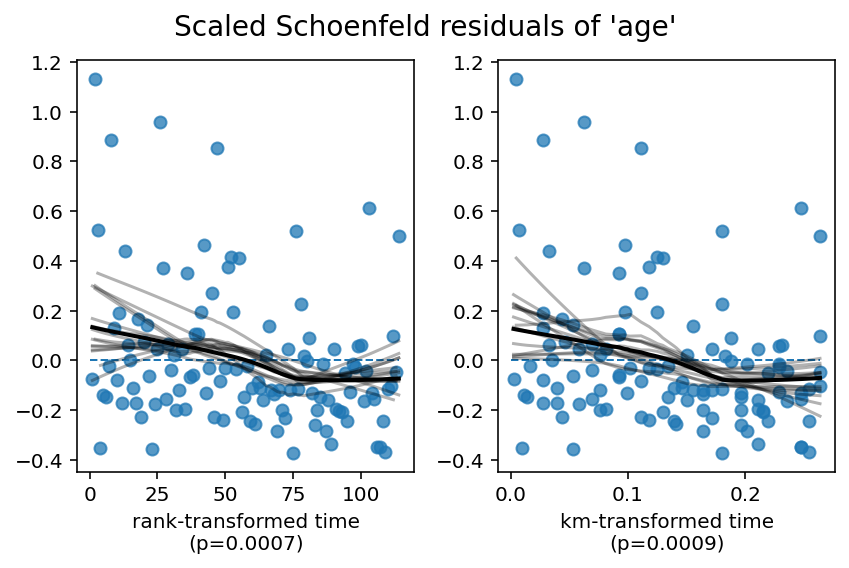

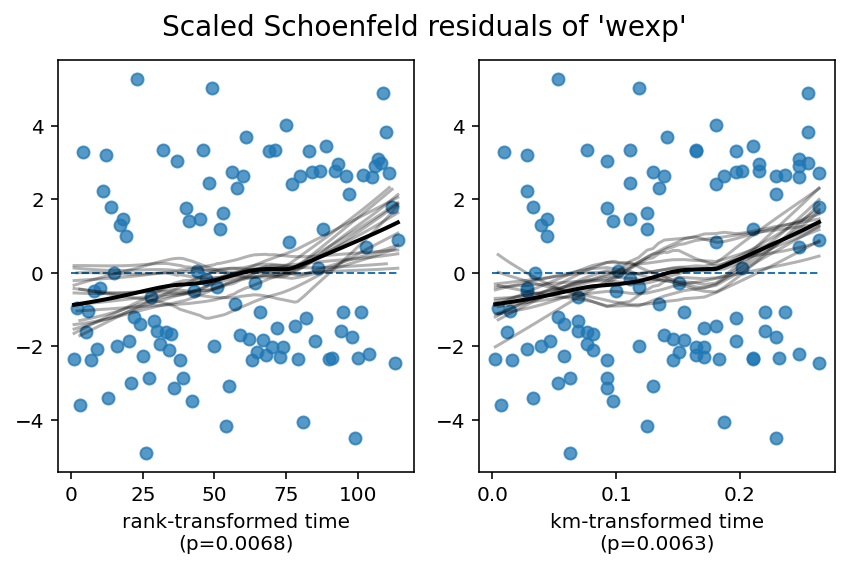

In [5]:
cph.check_assumptions(rossi, p_value_threshold=0.05, show_plots=True)

In [6]:
from lifelines.statistics import proportional_hazard_test

results = proportional_hazard_test(cph, rossi, time_transform='rank')
results.print_summary(decimals=3, model="untransformed variables")

<lifelines.StatisticalResult: proportional_hazard_test>
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 432 total observations, 318 right-censored observations>
         test_name = proportional_hazard_test

---
      test_statistic      p  -log2(p)
age            11.45 <0.005     10.45
fin             0.02   0.90      0.15
mar             0.71   0.40      1.32
paro            0.13   0.71      0.49
prio            0.02   0.89      0.17
race            1.43   0.23      2.11
wexp            7.31   0.01      7.19

In [7]:
# Stratification
cph.fit(rossi, 'week', 'arrest', strata=['wexp'])
cph.print_summary(model="wexp in strata")

<lifelines.CoxPHFitter: fitted with 432 total observations, 318 right-censored observations>
             duration col = 'week'
                event col = 'arrest'
                   strata = ['wexp']
      baseline estimation = breslow
   number of observations = 432
number of events observed = 114
   partial log-likelihood = -580.89
         time fit was run = 2020-12-02 20:13:45 UTC
                    model = wexp in strata

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
fin        -0.38       0.68       0.19            -0.76            -0.01                 0.47                 0.99
age        -0.06       0.94       0.02            -0.10            -0.01                 0.90                 0.99
race        0.31       1.36       0.31            -0.30             0.91                 0.74                 2.49
mar        -0.45       0.64       0.38            -1.20             0.29                 0.30                 1.34
paro       -0.08       0.92       0.20            -0.47             0.30                 0.63                 1.35
prio        0.09       1.09       0.03             0.03             0.15                 1.04                 1.16

              z      p   -log2(p)
covariate                        
fin       -1.99   0.05       4.42
age       -2.64   0.01       6.91
race       1.00   0.32       1.65
mar       -1.19   0.23       2.09
paro      -0.42   0.67       0.57
prio       3.16 <0.005       9.33
---
Concordance = 0.61
Partial AIC = 1173.77
log-likelihood ratio test = 23.77 on 6 df
-log2(p) of ll-ratio test = 10.77

The ``p_value_threshold`` is set at 0.01. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 432 total observations, 318 right-censored observations>
         test_name = proportional_hazard_test

---
           test_statistic      p  -log2(p)
age  km             11.29 <0.005     10.32
     rank            4.62   0.03      4.99
fin  km              0.02   0.90      0.16
     rank            0.05   0.83      0.28
mar  km              0.53   0.47      1.10
     rank            1.31   0.25      1.99
paro km              0.09   0.76      0.40
     rank            0.00   0.97      0.05
prio km              0.02   0.89      0.16
     rank            0.02   0.90      0.16
race km              1.47   0.23      2.15
     rank            0.64   0.42      1.23



1. Variable 'age' failed the non-proportional test: p-value is 0.0008.

   Advice 1: the functional form of the variable 'age' might be incorrect. That is, there may be
non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'age' using pd.cut, and then specify it in `strata=['age',
...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


   Bootstrapping lowess lines. May take a moment...


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Propor

[[<AxesSubplot:xlabel='rank-transformed time\n(p=0.0315)'>,
  <AxesSubplot:xlabel='km-transformed time\n(p=0.0008)'>]]

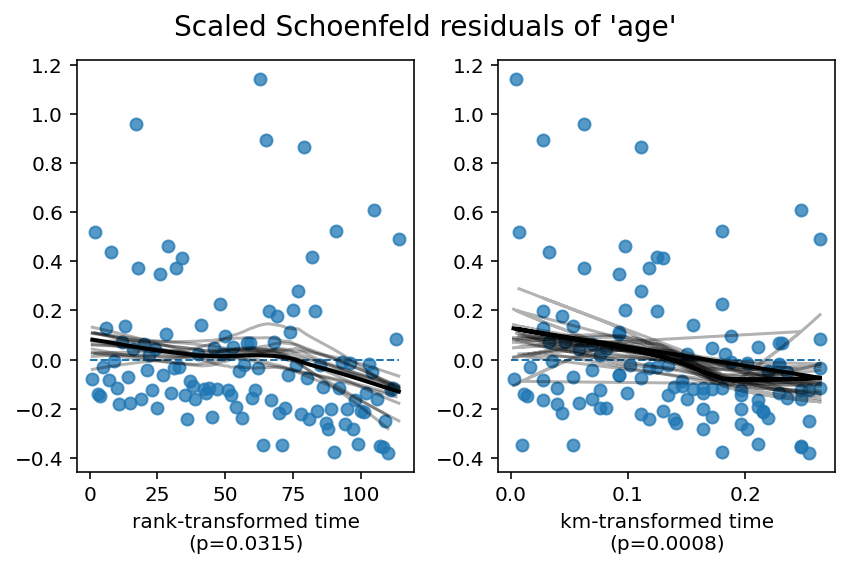

In [8]:
cph.check_assumptions(rossi, show_plots=True)

### H2O Samples

In [ ]:
import subprocess
import sys
import os

f = os.popen('sudo su; export PATH=$PATH:/opt/h2o; source ~/.bashrc')

In [ ]:
# Airline example
# https://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/algo-params/interaction_pairs.html
import h2o
h2o.init()
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

# import the airlines dataset
df_air = h2o.import_file("https://s3.amazonaws.com/h2o-public-test-data/smalldata/airlines/allyears2k_headers.zip")

# specify the columns to include
XY = [df_air.names[i-1] for i in [1,2,3,4,6,8,9,13,17,18,19,31]]

# specify the predictor column indices to interact
interactions = [XY[i-1] for i in [5,7,9]]

# train the model and build the coefficients table
m = H2OGeneralizedLinearEstimator(lambda_search=True,
                                  family="binomial",
                                  interactions=interactions)
m.train(x=XY[:len(XY)], y=XY[-1],training_frame=df)
coef_m = m._model_json['output']['coefficients_table']

# define specific interaction pairs
interaction_pairs = [("CRSDepTime", "UniqueCarrier"),
                     ("CRSDepTime", "Origin"),
                     ("UniqueCarrier", "Origin")]

# train the model with the interaction pairs
mexp = H2OGeneralizedLinearEstimator(lambda_search=True,
                                     family="binomial",
                                     interaction_pairs=interaction_pairs)
mexp.train(x=XY[:len(XY)], y=XY[-1],training_frame=df)
coef_mexp = mexp._model_json['output']['coefficients_table']

In [ ]:
df_air.head(5)

In [ ]:
# https://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/coxph.html
import h2o
from h2o.estimators.coxph import H2OCoxProportionalHazardsEstimator
h2o.init()

# Import the heart dataset into H2O:
heart = h2o.import_file("http://s3.amazonaws.com/h2o-public-test-data/smalldata/coxph_test/heart.csv")

# Split the dataset into a train and test set:
train, test = heart.split_frame(ratios = [.8], seed = 1234)

# Build and train the model:
heart_coxph = H2OCoxProportionalHazardsEstimator(start_column="start",
                                                 stop_column="stop",
                                                 ties="breslow")
heart_coxph.train(x="age",
            y="event",
            training_frame=train)

# Generate predictions on a test set (if necessary):
pred = heart_coxph.predict(test)

In [ ]:
a=heart["age"].ascharacter()
b=a.asfactor()
b.types

In [ ]:
# https://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/algo-params/stratify_by.html
import h2o
from h2o.estimators import H2OCoxProportionalHazardsEstimator
h2o.init()

# import the heart dataset:
heart = h2o.import_file("http://s3.amazonaws.com/h2o-public-test-data/smalldata/coxph_test/heart.csv")

# set the predictor and response column:
x = ["age", "year"]
y = "event"

# convert the age column to a factor:
heart["age"] = heart["age"].ascharacter()
heart["age"] = heart["age"].asfactor()

# build and train your model:
heart_coxph = H2OCoxProportionalHazardsEstimator(start_column="start",
                                                 stop_column="stop",
                                                 ties="breslow",
                                                 stratify_by=["age"])
heart_coxph.train(x=x, y=y, training_frame=heart)

# view the model details:
heart_coxph

In [ ]:
#############################################################
# Creation of Dummy variables to match Therneau model
#########################################################
data_modelt<-data_model
#large data set data_modelt

data_modelt$agecat62 <- ifelse(data_modelt$agecat6==2, 1,0) 
data_modelt$agecat63 <- ifelse(data_modelt$agecat6==3, 1,0)
data_modelt$agecat64 <- ifelse(data_modelt$agecat6==4, 1,0) 
data_modelt$agecat66 <- ifelse(data_modelt$agecat6==6, 1,0) 


data_modelt$agecat62p <- (ifelse(data_modelt$agecat6==2, 1,0))*data_modelt$pdiab
data_modelt$agecat63p <- (ifelse(data_modelt$agecat6==3, 1,0))*data_modelt$pdiab
data_modelt$agecat64p <- (ifelse(data_modelt$agecat6==4, 1,0))*data_modelt$pdiab
data_modelt$agecat66p <- (ifelse(data_modelt$agecat6==6, 1,0))*data_modelt$pdiab


data_modelt$pyf_period_esrd2p <- (ifelse(data_modelt$pyf_period_esrd==2, 1,0))*data_modelt$pdiab 
data_modelt$pyf_period_esrd3p <- (ifelse(data_modelt$pyf_period_esrd==3, 1,0))*data_modelt$pdiab 
data_modelt$pyf_period_esrd4p <- (ifelse(data_modelt$pyf_period_esrd==4, 1,0))*data_modelt$pdiab 
data_modelt$pyf_period_esrd5p <- (ifelse(data_modelt$pyf_period_esrd==5, 1,0))*data_modelt$pdiab 
data_modelt$pyf_period_esrd6p <- (ifelse(data_modelt$pyf_period_esrd==6, 1,0))*data_modelt$pdiab 

data_modelt$year2016 <- ifelse(data_modelt$year=="2016", 1,0) 
data_modelt$year2017 <- ifelse(data_modelt$year=="2017", 1,0)
data_modelt$year2018 <- ifelse(data_modelt$year=="2018", 1,0) 


data_modelt$inci_miss1<-as.numeric(as.character(data_modelt$inci_miss))
data_modelt$pdismiss1<-as.numeric(as.character(data_modelt$pdismiss))
data_modelt$bmi_msg1<-as.numeric(as.character(data_modelt$bmi_msg))
data_modelt$ashd11<-as.numeric(as.character(data_modelt$ashd1))

data_modelt$othcardiac11<-as.numeric(as.character(data_modelt$othcardiac1))
data_modelt$carfail1<-as.numeric(as.character(data_modelt$carfail))
data_modelt$noambul1<-as.numeric(as.character(data_modelt$noambul))
data_modelt$pulmon1<-as.numeric(as.character(data_modelt$pulmon))

data_modelt$notrans1<-as.numeric(as.character(data_modelt$notrans))
data_modelt$cancer1<-as.numeric(as.character(data_modelt$cancer))
data_modelt$diabetes1<-as.numeric(as.character(data_modelt$diabetes))
data_modelt$pvasc1<-as.numeric(as.character(data_modelt$pvasc))

data_modelt$cva1<-as.numeric(as.character(data_modelt$cva))
data_modelt$smoke1<-as.numeric(as.character(data_modelt$smoke))
data_modelt$alcoh1<-as.numeric(as.character(data_modelt$alcoh))
data_modelt$drug1<-as.numeric(as.character(data_modelt$drug))

data_modelt$inci_one1<-as.numeric(as.character(data_modelt$inci_one))
data_modelt$pnhprev1<-as.numeric(as.character(data_modelt$pnhprev))


In [ ]:
###################################################################################
# Matrix Reformulation of data_modelt using dummy variables  -  model1
####################################################################################

xf50<-as.matrix(cbind(data_modelt[, "agecat62"], data_modelt[, "agecat63"],data_modelt[, "agecat64"],data_modelt[, "agecat66"],
                      data_modelt[, "year2016"], data_modelt[, "year2017"],data_modelt[, "year2018"], data_modelt[, "bmi_msg1"],
                      data_modelt[, "pdismiss1"],data_modelt[, "pnhprev1"],
                      data_modelt[, "ashd11"], data_modelt[, "othcardiac11"],data_modelt[, "carfail1"],data_modelt[, "noambul1"], 
                      data_modelt[, "pulmon1"],data_modelt[, "notrans1"],data_modelt[, "cancer1"],data_modelt[, "diabetes1"],
                      data_modelt[, "pvasc1"],data_modelt[, "cva1"], data_modelt[, "smoke1"],data_modelt[, "alcoh1"],
                      data_modelt[, "drug1"], data_modelt[, "inci_one1"],data_modelt[, "inci_miss1"],
                      data_modelt[, "agecat62p"],data_modelt[, "agecat63p"], data_modelt[, "agecat64p"],data_modelt[, "agecat66p"],
                      data_modelt[, "pyf_period_esrd2p"],data_modelt[, "pyf_period_esrd3p"],data_modelt[, "pyf_period_esrd4p"],data_modelt[, "pyf_period_esrd5p"], data_modelt[, "pyf_period_esrd6p"],
                      data_modelt[, "pdiab"],data_modelt[, "logbmi"]
))
############################################################
# H2O Model coefficients rearranged to match survival model
############################################################

#Coef <- read_csv("Z:/Divya/h2o/Coef.csv")

#H2OCox<-Coef

#names(H2OCox)[2]<-"coef"

#names(H2OCox)[1]<-"var"

#H2OCoxT<-H2OCox[c(1,2,3,4,17:21,5,6,7,22:36,12:16,8:11),]

In [ ]:
#######################################################################################################
# Linear Predictor Calculations - from Terry Therneau equation - Model Means taken from H2O object
###############################################################################################



lpH2O<- c(xf50%*%coefficients_Stage_1) + data_modelt$ot_trans - sum(coefficients_Stage_1*colMeans(xf50))


###########################################################
# H2O Model Comparison using A. Weights Breslow H2O Cox PH Run - Best Model results
################################################################

modelH2OAWB<- coxph(Surv(t_start, t_stop, t_trans0)~1+ offset(lpH2O),
                    data=data_modelt, weights=wt_trans, ties="breslow", control=coxph_control)


data_modeltH2OAWB<-data_modelt

data_modeltH2OAWB$resid <- residuals(modelH2OAWB,type="martingale")

data_modeltH2OAWB$expecttr <- data_modeltH2OAWB$wt_trans*(data_modeltH2OAWB$t_trans0-data_modeltH2OAWB$resid)

#output expected number of transfusions along with id variables
expect_outH2OAWB<- data_modeltH2OAWB[ ,c("provfs","ptnt_id","year","strr_pyf_start","expecttr")]


In [ ]:
########################################################################################
# SECTION 14: SUMMARIZE TO FACILITY LEVEL AND OUTPUT STrR FOR EACH FACILITY COX H2O Model        #
########################################################################################

sub.dataH2OAWB <- data_modeltH2OAWB[ ,c("provfs","t_trans","expecttr")]

agg.dataH2OAWB <- aggregate(sub.dataH2OAWB[ ,-1], by=list(sub.dataH2OAWB$provfs), "sum")

sum.dataH2OAWB <- agg.dataH2OAWB[ ,c("Group.1","t_trans","expecttr")]

for (i in 1:nrow(sum.dataH2OAWB)){
  if (sum.dataH2OAWB$expecttr[i]>0) {
    sum.dataH2OAWB$strr[i] <- sum.dataH2OAWB$t_trans[i]/sum.dataH2OAWB$expecttr[i]
  }
}


colnames(sum.dataH2OAWB)[1] <- "provfs"
#print(sum.dataH2OAWB)

#boxplot(sum.dataH2OAWBCompare$strr_H2O_AWB, sum.dataH2OAWBCompare$strr_Legacy, names=c("H2O AWB Cox","Legacy Cox"),main="Comparison of STrR Ratios for H2O Cox vs Legacy Cox Model",ylim=c(0,3))

### Sparkling Test

In [ ]:
from pyspark.sql import SparkSession
# from pyspark import SparkConf, SparkContext
# import h2o
from pysparkling import *

spark = SparkSession\
    .builder\
    .appName("H2O_Test")\
    .getOrCreate()
conf = H2OConf().setExternalClusterMode().useManualClusterStart().setCloudName("test")
hc = H2OContext.getOrCreate(conf)

In [ ]:
spark.close()

## Power Plant Model

In [ ]:
# https://github.com/jakubhava/automl_blog_post

from pyspark.sql import SparkSession
from pysparkling import *

# spark = SparkSession\
#     .builder\
#     .appName("GeneralizedLinearRegressionExample")\
#     .getOrCreate()
spark = SparkSession.builder.appName("PowerPlantExample").getOrCreate()
conf = H2OConf().setExternalClusterMode().useManualClusterStart().setCloudName("test")
hc = H2OContext.getOrCreate()

In [ ]:
powerplant_df = spark.read.option("inferSchema", "true").csv("powerplant_output.csv", header=True)
splits = powerplant_df.randomSplit([0.8, 0.2], 1)
train = splits[0]
for_predictions = splits[1]

In [ ]:
from pysparkling.ml import H2OAutoML
from pyspark.ml import Pipeline
from pyspark.ml.feature import SQLTransformer
temperatureTransformer = SQLTransformer(statement="SELECT * FROM __THIS__ WHERE TemperatureCelcius > 10")

In [ ]:
temperatureTransformer.transform(powerplant_df).show()

In [ ]:
automlEstimator = H2OAutoML(maxRuntimeSecs=60, predictionCol="HourlyEnergyOutputMW")

In [ ]:
pipeline = Pipeline(stages=[temperatureTransformer.transform(powerplant_df), automlEstimator])
# pipeline = Pipeline(stages=[automlEstimator])

In [ ]:
powerplant_df.head(2)

In [ ]:
train.head(2)

In [ ]:
for_predictions.head(2)

In [ ]:
model = automlEstimator.fit(train)

In [ ]:
from pyspark.ml.regression import AFTSurvivalRegression 
from pyspark.ml.linalg import Vectors

In [ ]:

from pyspark.sql import SparkSession
# $example on$
from pyspark.ml.regression import GeneralizedLinearRegression
# $example off$

if __name__ == "__main__":
    spark = SparkSession\
        .builder\
        .appName("GeneralizedLinearRegressionExample")\
        .getOrCreate()

    # $example on$
    # Load training data
    dataset = spark.read.format("libsvm")\
        .load("s3://eqrs-ngmc-datascience/Datascience/x.csv")

In [ ]:
from pyspark.sql import SparkSession
# $example on$
from pyspark.ml.regression import GeneralizedLinearRegression
# $example off$

if __name__ == "__main__":
    spark = SparkSession\
        .builder\
        .appName("GeneralizedLinearRegressionExample")\
        .getOrCreate()

    # $example on$
    # Load training data
    dataset = spark.read.format("libsvm")\
        .load("sample_linear_regression_data.txt")

    family = ("gaussian","Gamma")
    link=("identity", "Log", "Inverse")
    maxIter=(10,100,1000)
    regParam=(0.1, 0.3, 0.5)
    params = [[i, j, k, l] for i in family  
                     for j in link 
                     for k in maxIter
                     for l in regParam] 
    for p in params:
        glr = GeneralizedLinearRegression(family=p[0], link=p[1], maxIter=p[2], regParam=p[3])

        # Fit the model
        model = glr.fit(dataset)

        # Print the coefficients and intercept for generalized linear regression model
        print("Coefficients: " + str(model.coefficients))
        print("Intercept: " + str(model.intercept))

        # Summarize the model over the training set and print out some metrics
        print(p);print();print()
        summary = model.summary
        print("Coefficient Standard Errors: " + str(summary.coefficientStandardErrors))
        print("T Values: " + str(summary.tValues))
        print("P Values: " + str(summary.pValues))
        print("Dispersion: " + str(summary.dispersion))
        print("Null Deviance: " + str(summary.nullDeviance))
        print("Residual Degree Of Freedom Null: " + str(summary.residualDegreeOfFreedomNull))
        print("Deviance: " + str(summary.deviance))
        print("Residual Degree Of Freedom: " + str(summary.residualDegreeOfFreedom))
        print("AIC: " + str(summary.aic))
        print("Deviance Residuals: ")
        summary.residuals().show()
        # $example off$

    spark.stop()